In [1]:
import attack_kernelbased
import attack_fgsm
import attack_df
import attack_jsma
import attack_gen
import dataloader
import spatial

import torch
import torch.nn as nn
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm
import copy

In [2]:
X_train, X_test, y_train, y_test = dataloader.load(dataset_name='isolet')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6238, 617]),
 torch.Size([1559, 617]),
 torch.Size([6238]),
 torch.Size([1559]))

In [3]:
X_test = X_test[:1000]
y_test = y_test[:1000]

100%|██████████| 30/30 [01:18<00:00,  2.61s/it]


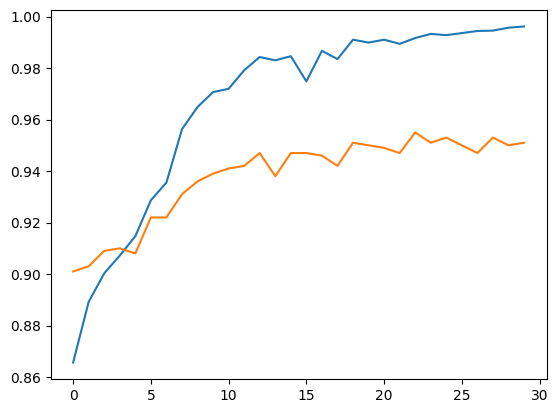

0.9961526393890381 0.9549999833106995


In [4]:
D = 4000
acc_history, test_acc_history = [], []
model = onlinehd.OnlineHD(classes, features, dim=D)
best_model = None
for _ in tqdm.tqdm(range(30)):
  model = model.fit(X_train, y_train, bootstrap=1.0, lr=0.035, epochs=1, one_pass_fit=False)
  
  yhat_train = model(X_train)
  yhat_test = model(X_test)

  acc = (y_train == yhat_train).float().mean().item()
  acc_test = (y_test == yhat_test).float().mean().item()

  if best_model is None or max(test_acc_history) < acc_test:
    best_model = copy.deepcopy(model)

  acc_history.append(acc)
  test_acc_history.append(acc_test)
model = best_model

plt.plot(acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.show()
print(max(acc_history), max(test_acc_history))

In [5]:
with open('./onlinehd_isolet.pickle', 'bw') as f:
    pickle.dump(model, f)

In [4]:
with open('./onlinehd_isolet.pickle', 'br') as f:
    model = pickle.load(f)

In [5]:
model_dnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features)
model_dnn.load_state_dict(torch.load('./model_dnn_isolet.pt'))
model_dnn.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=617, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=26, bias=True)
  )
)

## Kernel based attack

In [8]:
# with complex encoding (FHRR)
for e in np.linspace(0.01, 0.1, 10):#[0.01, 0.03, 0.07, 0.1]:
    st = time.time()
    X_test_noised = attack_kernelbased.genAdversarialNoise(model, X_test, y_test, e)
    print(time.time() - st)
    
    yhat_test = model(X_test_noised)
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:33<00:00, 29.84it/s]


34.16470980644226
0.01 0.009550000540912151 0.9190000295639038 0.9390000104904175


100%|██████████| 1000/1000 [00:33<00:00, 30.18it/s]


33.66814589500427
0.020000000000000004 0.019100001081824303 0.8840000033378601 0.921999990940094


100%|██████████| 1000/1000 [00:33<00:00, 29.56it/s]


34.40758800506592
0.030000000000000006 0.02865000069141388 0.8410000205039978 0.9079999923706055


100%|██████████| 1000/1000 [00:34<00:00, 29.01it/s]


34.98910593986511
0.04000000000000001 0.038200002163648605 0.7760000228881836 0.8939999938011169


100%|██████████| 1000/1000 [00:33<00:00, 29.44it/s]


34.5184850692749
0.05000000000000001 0.04775000363588333 0.7139999866485596 0.8769999742507935


100%|██████████| 1000/1000 [00:33<00:00, 29.62it/s]


34.36953091621399
0.06000000000000001 0.05730000138282776 0.6389999985694885 0.8529999852180481


100%|██████████| 1000/1000 [00:35<00:00, 28.26it/s]


35.99789500236511
0.07 0.06685000658035278 0.5720000267028809 0.824999988079071


100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s]


35.40586018562317
0.08 0.07640000432729721 0.503000020980835 0.7940000295639038


100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s]


35.4068329334259
0.09000000000000001 0.08595000207424164 0.44699999690055847 0.7519999742507935


100%|██████████| 1000/1000 [00:35<00:00, 27.78it/s]


36.59141206741333
0.1 0.09550000727176666 0.39500001072883606 0.6990000009536743


## FGSM

### Normlized

In [9]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
#criterion = nn.CosineEmbeddingLoss()
criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm.attack(
    model, X_train, X_test, y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu', 
    input_dim=features, model_type='dnn')

100%|██████████| 1000/1000 [00:04<00:00, 234.59it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 4.265593416999991 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 95.30%
mean of norm=0.009999996051192284


100%|██████████| 1000/1000 [00:04<00:00, 211.15it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 4.743320166999979 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 95.30%
mean of norm=0.019999997690320015


100%|██████████| 1000/1000 [00:05<00:00, 181.88it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 5.506840041999965 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 95.10%
mean of norm=0.029999980702996254


100%|██████████| 1000/1000 [00:04<00:00, 232.17it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 4.317116749999968 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 95.20%
mean of norm=0.03999999910593033


100%|██████████| 1000/1000 [00:04<00:00, 210.86it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 4.756658082999934 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 94.90%
mean of norm=0.05000000447034836


100%|██████████| 1000/1000 [00:04<00:00, 203.08it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 4.932531416000074 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 94.90%
mean of norm=0.0599999725818634


100%|██████████| 1000/1000 [00:04<00:00, 211.64it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 4.733118540999953 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 94.50%
mean of norm=0.06999999284744263


100%|██████████| 1000/1000 [00:04<00:00, 204.09it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 4.907588166999972 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 94.60%
mean of norm=0.07999999821186066


100%|██████████| 1000/1000 [00:04<00:00, 203.83it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 4.916357541000025 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 94.30%
mean of norm=0.09000000357627869


100%|██████████| 1000/1000 [00:04<00:00, 202.06it/s]


FGSM Attack with epsilon = 0.10000 | Elapsed time: 4.957733875000031 seconds.
Accuracy: Before the attack -> 95.50%	|	After the attack -> 94.20%
mean of norm=0.10000000894069672


In [10]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

0.01 0.009999996051192284 0.953000009059906 0.9520000219345093
0.020000000000000004 0.019999997690320015 0.953000009059906 0.9520000219345093
0.030000000000000006 0.029999980702996254 0.9509999752044678 0.9509999752044678
0.04000000000000001 0.03999999910593033 0.9520000219345093 0.949999988079071
0.05000000000000001 0.05000000447034836 0.9490000009536743 0.949999988079071
0.06000000000000001 0.0599999725818634 0.9490000009536743 0.9490000009536743
0.07 0.06999999284744263 0.9449999928474426 0.9490000009536743
0.08 0.07999999821186066 0.9459999799728394 0.9470000267028809
0.09000000000000001 0.09000000357627869 0.9430000185966492 0.9449999928474426
0.1 0.10000000894069672 0.9419999718666077 0.9470000267028809


## Deep Fool

In [6]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, features)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], features)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=max_update, num_classes=classes, input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


340.08926486968994
0.01 0.003637996269389987 0.9309999942779541 0.9419999718666077


100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s]


362.37019395828247
0.02 0.007275993004441261 0.9079999923706055 0.9290000200271606


100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]


337.50009989738464
0.03 0.010913989506661892 0.8679999709129333 0.921999990940094


100%|██████████| 1000/1000 [04:35<00:00,  3.62it/s]


275.86575722694397
0.04 0.014551986008882523 0.8040000200271606 0.9139999747276306


100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


252.83658504486084
0.05 0.018189983442425728 0.7419999837875366 0.9020000100135803


100%|██████████| 1000/1000 [03:34<00:00,  4.67it/s]


214.30184698104858
0.060000000000000005 0.021827979013323784 0.6669999957084656 0.890999972820282


100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


194.69384789466858
0.06999999999999999 0.02546597272157669 0.6499999761581421 0.8690000176429749


100%|██████████| 1000/1000 [14:50<00:00,  1.12it/s] 


890.4744050502777
0.08 0.029103972017765045 0.6499999761581421 0.8479999899864197


100%|██████████| 1000/1000 [15:10<00:00,  1.10it/s] 


910.3153319358826
0.09 0.0327419713139534 0.6499999761581421 0.8240000009536743


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


177.3129918575287
0.09999999999999999 0.036379966884851456 0.6499999761581421 0.7990000247955322


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


171.7412588596344
0.11 0.04001795873045921 0.6499999761581421 0.7799999713897705


100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]


178.38594007492065
0.12 0.04365595802664757 0.6499999761581421 0.7670000195503235


100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


174.8645520210266
0.13 0.047293949872255325 0.6499999761581421 0.7490000128746033


100%|██████████| 1000/1000 [02:41<00:00,  6.18it/s]


161.75405597686768
0.14 0.05093194544315338 0.6499999761581421 0.7310000061988831


100%|██████████| 1000/1000 [02:23<00:00,  6.98it/s]


143.36693596839905
0.15000000000000002 0.054569944739341736 0.6499999761581421 0.7179999947547913


100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s]


149.45582604408264
0.16 0.05820794403553009 0.6499999761581421 0.7039999961853027


100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]


153.0751597881317
0.17 0.06184593215584755 0.6499999761581421 0.6970000267028809


100%|██████████| 1000/1000 [02:25<00:00,  6.86it/s]


145.70300388336182
0.18000000000000002 0.0654839426279068 0.6499999761581421 0.6919999718666077


100%|██████████| 1000/1000 [02:28<00:00,  6.72it/s]


148.89637780189514
0.19 0.06912193447351456 0.6499999761581421 0.6840000152587891


100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


149.62165594100952
0.2 0.07275993376970291 0.6499999761581421 0.6790000200271606


In [7]:
X_te_cln = X_test.clone().reshape(-1, 1, features)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], features)

for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=None, num_classes=classes, input_dim=features, model_type='dnn')

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test = model(X_test_noised.reshape(-1, features))
yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


None 0.0395655520260334 0.6499999761581421 0.7649999856948853


## Genetic Attack

In [13]:
alpha_lis = np.linspace(0.0001, 0.0015, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen.make_GA(model, delta, alpha, x_test_samp, y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, dnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0001


100%|██████████| 1000/1000 [1:35:39<00:00,  5.74s/it]


5739.920543909073
0.0001 0.022498110309243202 0.9509999752044678 0.9520000219345093
Alpha : 0.0001736842105263158


100%|██████████| 1000/1000 [1:33:47<00:00,  5.63s/it]


5627.550845861435
0.0001736842105263158 0.03852307051420212 0.949999988079071 0.9509999752044678
Alpha : 0.0002473684210526316


100%|██████████| 1000/1000 [1:33:36<00:00,  5.62s/it]


5616.200036048889
0.0002473684210526316 0.05439358204603195 0.9480000138282776 0.9470000267028809
Alpha : 0.00032105263157894735


100%|██████████| 1000/1000 [1:33:45<00:00,  5.63s/it]


5625.925188064575
0.00032105263157894735 0.07048539072275162 0.9490000009536743 0.9459999799728394
Alpha : 0.00039473684210526315


100%|██████████| 1000/1000 [1:34:22<00:00,  5.66s/it]


5662.6135330200195
0.00039473684210526315 0.08633758872747421 0.9430000185966492 0.9449999928474426
Alpha : 0.00046842105263157895


100%|██████████| 1000/1000 [1:33:57<00:00,  5.64s/it]


5637.309382915497
0.00046842105263157895 0.10158946365118027 0.9430000185966492 0.9399999976158142
Alpha : 0.0005421052631578948


100%|██████████| 1000/1000 [1:35:01<00:00,  5.70s/it]


5701.246057987213
0.0005421052631578948 0.11339505761861801 0.9359999895095825 0.9380000233650208
Alpha : 0.0006157894736842106


100%|██████████| 1000/1000 [1:35:29<00:00,  5.73s/it]


5729.609946966171
0.0006157894736842106 0.11759191751480103 0.9399999976158142 0.9409999847412109
Alpha : 0.0006894736842105264


100%|██████████| 1000/1000 [1:36:25<00:00,  5.79s/it]


5785.885804891586
0.0006894736842105264 0.11928137391805649 0.9390000104904175 0.9380000233650208
Alpha : 0.0007631578947368421


100%|██████████| 1000/1000 [1:36:46<00:00,  5.81s/it]


5807.092231988907
0.0007631578947368421 0.12612183392047882 0.9459999799728394 0.9419999718666077
Alpha : 0.000836842105263158


100%|██████████| 1000/1000 [1:39:25<00:00,  5.97s/it]


5965.281290054321
0.000836842105263158 0.12491637468338013 0.9350000023841858 0.9369999766349792
Alpha : 0.0009105263157894737


100%|██████████| 1000/1000 [1:37:12<00:00,  5.83s/it]


5832.31508398056
0.0009105263157894737 0.12473554909229279 0.9369999766349792 0.9380000233650208
Alpha : 0.0009842105263157895


100%|██████████| 1000/1000 [1:45:15<00:00,  6.32s/it]


6315.47539806366
0.0009842105263157895 0.12889127433300018 0.9359999895095825 0.9380000233650208
Alpha : 0.0010578947368421053


100%|██████████| 1000/1000 [1:41:32<00:00,  6.09s/it]


6092.963121175766
0.0010578947368421053 0.13029541075229645 0.9359999895095825 0.9350000023841858
Alpha : 0.0011315789473684212


100%|██████████| 1000/1000 [1:54:15<00:00,  6.86s/it]


6855.137047767639
0.0011315789473684212 0.13153688609600067 0.9319999814033508 0.9390000104904175
Alpha : 0.0012052631578947368


100%|██████████| 1000/1000 [1:42:13<00:00,  6.13s/it]


6133.752470970154
0.0012052631578947368 0.13208921253681183 0.9380000233650208 0.9369999766349792
Alpha : 0.0012789473684210527


100%|██████████| 1000/1000 [1:41:10<00:00,  6.07s/it]


6070.798237085342
0.0012789473684210527 0.1304032951593399 0.9390000104904175 0.9359999895095825
Alpha : 0.0013526315789473685


100%|██████████| 1000/1000 [1:41:02<00:00,  6.06s/it]


6062.559363126755
0.0013526315789473685 0.13242025673389435 0.9409999847412109 0.9390000104904175
Alpha : 0.0014263157894736842


100%|██████████| 1000/1000 [1:38:34<00:00,  5.91s/it]


5914.516623973846
0.0014263157894736842 0.13350670039653778 0.9399999976158142 0.9380000233650208
Alpha : 0.0015


100%|██████████| 1000/1000 [1:34:22<00:00,  5.66s/it]


5662.736827135086
0.0015 0.13409391045570374 0.9409999847412109 0.9380000233650208
